In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class BayesianClassifier:
    def __init__(self):
        # will store parameters for each class
        self.priors = {}
        self.means = {}
        self.vars = {}
        self.classes = None

    def fit(self, X, y):
        """
        X : numpy array of shape (n_samples, n_features)
        y : array of shape (n_samples,), class labels (integers or hashable)
        """
        self.classes = np.unique(y)
        n, d = X.shape

        for c in self.classes:
            Xc = X[y == c]
            # prior P(y = c)
            self.priors[c] = Xc.shape[0] / n
            # estimate mean and variance of each feature for that class
            self.means[c] = np.mean(Xc, axis=0)
            # use unbiased estimator (or add a small smoothing term)
            self.vars[c] = np.var(Xc, axis=0) + 1e-6   # avoid zero variance

    def _likelihood(self, x, c):
        """
        Compute p(x | y = c) under independent Gaussian assumption:
        product over features of N(x_i; mean_c_i, var_c_i)
        """
        mean = self.means[c]
        var = self.vars[c]
        # Gaussian likelihood per feature
        # using formula: (1 / sqrt(2π var)) * exp( - (x - mean)^2 / (2 var) )
        # For numerical stability, compute log‐likelihood and exponentiate later or compare logs
        exponent = -0.5 * np.sum((x - mean) ** 2 / var)
        denom = np.sqrt((2 * np.pi) ** len(x) * np.prod(var))
        return np.exp(exponent) / denom

    def predict(self, X):
        """
        Predict class labels for X (array shape (n_samples, n_features))
        """
        y_pred = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                # unnormalized posterior = prior * likelihood
                posteriors[c] = self.priors[c] * self._likelihood(x, c)
            # choose class with maximum posterior
            y_pred.append(max(posteriors, key=posteriors.get))
        return np.array(y_pred)

    def predict_log(self, X):
        """
        Alternative: use log probabilities to avoid underflow.
        """
        y_pred = []
        for x in X:
            log_post = {}
            for c in self.classes:
                # log P(y=c) + log p(x | y=c)
                log_prior = np.log(self.priors[c])
                # log likelihood
                mean = self.means[c]
                var = self.vars[c]
                log_lik = -0.5 * np.sum((x - mean) ** 2 / var + np.log(2 * np.pi * var))
                log_post[c] = log_prior + log_lik
            y_pred.append(max(log_post, key=log_post.get))
        return np.array(y_pred)


if __name__ == "__main__":
    # toy example using synthetic data
    # say two classes, 2D features
    np.random.seed(0)
    # class 0:
    X0 = np.random.normal(loc=0.0, scale=1.0, size=(100, 2))
    # class 1:
    X1 = np.random.normal(loc=3.0, scale=1.5, size=(100, 2))
    X = np.vstack([X0, X1])
    y = np.array([0]*100 + [1]*100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = BayesianClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict_log(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9666666666666667


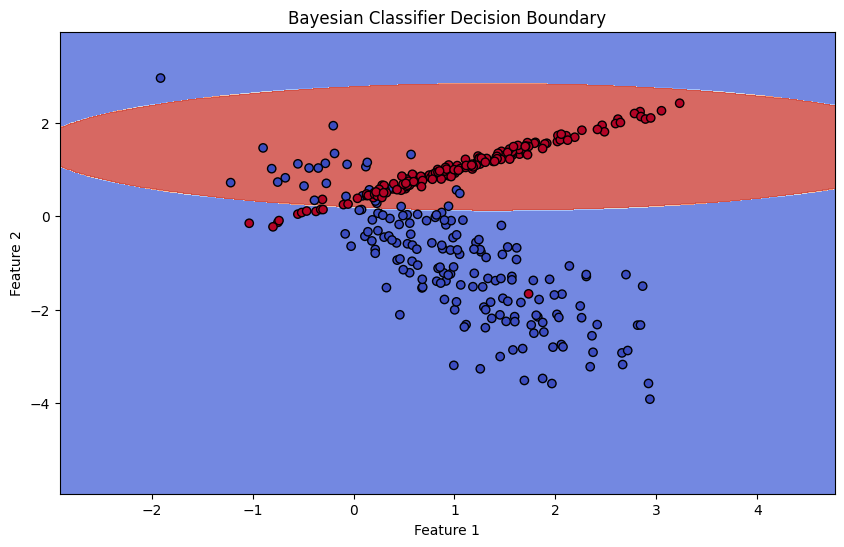

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

class BayesianClassifier:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.vars = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n, d = X.shape
        for c in self.classes:
            Xc = X[y == c]
            self.priors[c] = Xc.shape[0] / n
            self.means[c] = np.mean(Xc, axis=0)
            self.vars[c] = np.var(Xc, axis=0) + 1e-6

    def _likelihood(self, x, c):
        mean = self.means[c]
        var = self.vars[c]
        exponent = -0.5 * np.sum((x - mean) ** 2 / var)
        denom = np.sqrt((2 * np.pi) ** len(x) * np.prod(var))
        return np.exp(exponent) / denom

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                posteriors[c] = self.priors[c] * self._likelihood(x, c)
            y_pred.append(max(posteriors, key=posteriors.get))
        return np.array(y_pred)

# Generate synthetic 2D data
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classifier
clf = BayesianClassifier()
clf.fit(X_train, y_train)

# Create a mesh grid for plotting
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict class labels for each point in the mesh grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title("Bayesian Classifier Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()